# create $cya$ - "Compare Your Abundances" creation

The intend of this notebook is to read in existing high-quality literature data of elemental abundances and homogenise them to use the same keywords.
They are then stored in directories for individual elements to allow everyone to just read in the relevant ones for each element.

In [31]:
# Preamble 
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# general packages
import numpy as np
from pathlib import Path
import warnings
import glob
from astroquery.vizier import Vizier

# astropy
from astropy.table import Table,join,hstack,vstack
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
from astropy.units import UnitsWarning
warnings.filterwarnings('ignore', category=UnitsWarning, module='astropy.units.core')

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rcParams
rcParams['axes.labelsize'] = 15
rcParams['legend.fontsize'] = 15
rcParams['figure.titlesize'] = 20

panels = [
    'a)','b)','c)',
    'd)','e)','f)',
    'g)','h)','i)',
    'j)','k)','l)',
    'm)','n)','o)',
    'q)','r)','s)',
    't)','u)','v)',
    'w)','x)','y)',
    'z)','aa)','ab)',
    'ac)','ad)','ae)'
]

In [3]:
# These are the elements reported by the APOGEE and GALAH surveys
elements = [
    'Li',
    'C','N','O',
    'Na','Mg','Al','Si','P','S',
    'K','Ca','Sc','Ti','V','Cr','Mn','Fe','Co','Ni','Cu','Zn',
    'Rb','Sr','Y','Zr','Mo','Ru',
    'Ba',
    'La','Ce','Nd','Sm','Eu','Yb'
]

In [4]:
# Are we overwriting existing homogenised FITS tables?
overwrite_existing = True

In [5]:
# What are the mandatory keywords that every FITS table needs to have?
mandatory_keywords = [
    'tmass_id',
    'ra',
    'dec',
    'teff',
    'logg',
    'fe_h',
    'e_fe_h'
]

# 1. Literature Data

## 1.1 Download Literature from VizieR

The literature data is typically downloaded from the VizieR interface (https://vizier.cds.unistra.fr) with the following preferences:  
- max : unlimited entries  
- type : FITS (binary) Table
- all column check

as a binary FITS table with all VizieR columns, that is, also including _RA and _DE coordinates for J2000.

Follow the directory and path convention:

```
literature_raw_files/"+LastNameOfFirstAuthor+"_"+ADS_Bibcode+"_VizieR.fits
```

For example, for the Bensby et al. (2014) work with ADS_Bibcode 2014A&A...562A..71B:
```
literature_raw_files/Bensby_2014A&A...562A..71B_VizieR.fits
```

In [520]:
# Identify all available literature
# Note that we expect the file paths
# to start with the 21 characters "literature_raw_files/"
#  and end with the 12 characters "_VizieR.fits"
available_literature = [x[21:-12] for x in glob.glob('literature_raw_files/*_VizieR.fits')]
available_literature.sort()
available_literature

['Battistini_2015A&A...577A...9B',
 'Battistini_2016A&A...586A..49B',
 'Bensby_2014A&A...562A..71B',
 'Bensby_2017A&A...605A..89B',
 'Bensby_2018A%26A...615A.151B',
 'Bensby_2020A&A...634A.130B',
 'Bensby_2021A&A...655A.117B',
 'Forsberg_2019A&A...631A.113F',
 'Forsberg_2022A&A...666A.125F',
 'Joensson_2017A&A...598A.100J',
 'Montelius_2022A&A...665A.135M',
 'Nissen_2010A&A...511L..10N',
 'Nissen_2011A&A...530A..15N',
 'Nissen_2012A%26A...543A..28N',
 'Nissen_2014A&A...568A..25N',
 'Nissen_2020A&A...640A..81N',
 'Nissen_2024A&A...682A.116N']

## 1.2 Concatenating of extensions

Some authors upload their data in multiple tables -> this will create multiple FITS extensions.  
If they do, the code of Section 1.3 will fail and tell you to create a VizieR FITS File with only one extension.
I would suggest to either merge extensions in TOPCAT, or with astropy.table.Table

This has been done to the following VizieR.fits files:



In [532]:
def check_for_extra_fits_extensions(literature_file):
    
    fits_file = fits.open('literature_raw_files/'+literature_file+'_VizieR.fits')
    
    if len(fits_file) <= 2:
        print('1 FITS extension for '+literature_file+'.')
        table = Table.read('literature_raw_files/'+literature_file+'_VizieR.fits')
        table.write('literature_raw_files/'+literature_file+'_VizieR_merged.fits', overwrite = True)
    else:
        if literature_file in [
            'Bensby_2014A&A...562A..71B','Bensby_2017A&A...605A..89B',
            'Forsberg_2019A&A...631A.113F','Forsberg_2022A&A...666A.125F',
            'Montelius_2022A&A...665A.135M',
            'Nissen_2010A&A...511L..10N','Nissen_2011A&A...530A..15N',
            'Nissen_2014A&A...568A..25N','Nissen_2020A&A...640A..81N'
        ]:
            print(str(len(fits_file)-1)+' FITS extensions for '+literature_file+'. But already merged.')
        else:
            print('--> '+str(len(fits_file)-1)+' FITS extensions for '+literature_file+'. You first need to merge them before you can continue!')
    fits_file.close()

In [533]:
for literature_file in available_literature:
    check_for_extra_fits_extensions(literature_file)

1 FITS extension for Battistini_2015A&A...577A...9B.
1 FITS extension for Battistini_2016A&A...586A..49B.
3 FITS extensions for Bensby_2014A&A...562A..71B. But already merged.
2 FITS extensions for Bensby_2017A&A...605A..89B. But already merged.
1 FITS extension for Bensby_2018A%26A...615A.151B.
1 FITS extension for Bensby_2020A&A...634A.130B.
1 FITS extension for Bensby_2021A&A...655A.117B.
1 FITS extension for Forsberg_2019A&A...631A.113F.
4 FITS extensions for Forsberg_2022A&A...666A.125F. But already merged.
1 FITS extension for Joensson_2017A&A...598A.100J.
2 FITS extensions for Montelius_2022A&A...665A.135M. But already merged.
2 FITS extensions for Nissen_2010A&A...511L..10N. But already merged.
2 FITS extensions for Nissen_2011A&A...530A..15N. But already merged.
1 FITS extension for Nissen_2012A%26A...543A..28N.
2 FITS extensions for Nissen_2014A&A...568A..25N. But already merged.
2 FITS extensions for Nissen_2020A&A...640A..81N. But already merged.
1 FITS extension for Nissen

## 1.3 Match to the parent catalogue (i.e. either 2MASS or Gaia DR3)

In [534]:
def find_closest_2mass_sources(literature_file):
    
    try:
        fits_file = fits.open('literature_raw_files/'+literature_file+'_VizieR_merged.fits')
        
        # Some authors upload their data in multiple tables -> this will create multiple FITS extensions
        # Check if we have multiple extensions in the VizieR file.
        if len(fits_file) > 2:
            raise ValueError(literature_file+' has '+str(len(fits_file))+' extensions\nFirst join/concatenate the entries to only have 1 extension.')
    
        fits_file.close()
    except:
        raise FileNotFoundError('You first need to create a _VizieR_merged.fits file for '+literature_file)
        
    fits_file = Table.read('literature_raw_files/'+literature_file+'_VizieR_merged.fits')
    
    # First identify the Right Ascension (RA) and Declination (DE)
    # They come with different column names of course...
    try:
        ra, dec = (fits_file['RAJ2000'],fits_file['DEJ2000'])
    except:
        try:
            ra, dec = (fits_file['_RAJ2000'],fits_file['_DEJ2000'])
        except:
            ra, dec = (fits_file['_RA'],fits_file['_DE'])
    
    # Create an in-memory table for the coordinates
    coords = SkyCoord(ra=ra, dec=dec, unit=(u.deg, u.deg))
    
    # Query Vizier for the 2MASS catalog
    vizier = Vizier(columns=['RAJ2000', 'DEJ2000', '2MASS'])
    vizier.ROW_LIMIT = -1  # no row limit
    result = vizier.query_region(coords, radius=2*u.arcsec, catalog='II/246/out')
    
    if not result:
        raise ValueError("No results found in 2MASS catalog.")
    
    # Extract the result table
    tmass_result = result[0]
    
    # Create a SkyCoord object for the query results
    tmass_coords = SkyCoord(ra=tmass_result['RAJ2000'], dec=tmass_result['DEJ2000'], unit=(u.deg, u.deg))
    
    # Match the input coordinates to the query results
    idx, sep, _ = coords.match_to_catalog_sky(tmass_coords)
    
    tmass_ids = []
    for i, j in enumerate(idx):
        if sep[i].arcsec < 2:
            tmass_ids.append(tmass_result['_2MASS'][j])
        else:
            tmass_ids.append('')
            
    fits_file['tmass_id'] = np.array(tmass_ids, dtype=str)
    
    fits_file.write('literature_raw_files/'+literature_file+'_VizieR_merged_tmass_id.fits',overwrite=True)
    
    print("Added 2MASS ID as 'tmass_id' to "+literature_file)

In [535]:
for literature_file in available_literature:
    find_closest_2mass_sources(literature_file)

Added 2MASS ID as 'tmass_id' to Battistini_2015A&A...577A...9B
Added 2MASS ID as 'tmass_id' to Battistini_2016A&A...586A..49B
Added 2MASS ID as 'tmass_id' to Bensby_2014A&A...562A..71B
Added 2MASS ID as 'tmass_id' to Bensby_2017A&A...605A..89B
Added 2MASS ID as 'tmass_id' to Bensby_2018A%26A...615A.151B
Added 2MASS ID as 'tmass_id' to Bensby_2020A&A...634A.130B
Added 2MASS ID as 'tmass_id' to Bensby_2021A&A...655A.117B
Added 2MASS ID as 'tmass_id' to Forsberg_2019A&A...631A.113F
Added 2MASS ID as 'tmass_id' to Forsberg_2022A&A...666A.125F
Added 2MASS ID as 'tmass_id' to Joensson_2017A&A...598A.100J
Added 2MASS ID as 'tmass_id' to Montelius_2022A&A...665A.135M
Added 2MASS ID as 'tmass_id' to Nissen_2010A&A...511L..10N
Added 2MASS ID as 'tmass_id' to Nissen_2011A&A...530A..15N
Added 2MASS ID as 'tmass_id' to Nissen_2012A%26A...543A..28N
Added 2MASS ID as 'tmass_id' to Nissen_2014A&A...568A..25N
Added 2MASS ID as 'tmass_id' to Nissen_2020A&A...640A..81N
Added 2MASS ID as 'tmass_id' to Nis

## 1.4 Unified Keywords

In [536]:
flag_good         = 0
flag_upper_limit  = 1
flag_no_detection = 2

In [595]:
def unify_keywords(literature_file):
    """
    This function unifies the keywords of the merged VizieR catalogues.
    
    This needs to be extended for new literature data.
    """
    
    raw_data = Table.read('literature_raw_files/'+literature_file+'_VizieR_merged_tmass_id.fits')
    oid = np.arange(len(raw_data['tmass_id']))
    
    author, ads_bibcode = literature_file.split('_')
    raw_data['author']      = [author+'+'+ads_bibcode[:4] for entry in oid]
    raw_data['ads_bibcode'] = [ads_bibcode for entry in oid]
    
    unified_table = Table()
    unified_keywords = dict()
    
    if literature_file == 'Battistini_2015A&A...577A...9B':
        
        unified_keywords['author']      = 'author'
        unified_keywords['ads_bibcode'] = 'ads_bibcode'
        unified_keywords['tmass_id']    = 'tmass_id'
        unified_keywords['ra']          = '_RA'
        unified_keywords['dec']         = '_DE'
        
        # Note: Battistini_2015A&A...577A...9B used Teff/logg/[Fe/H]/vmic from Bensby_2014A&A...562A..71B
        # We therefore propagate the latter values (more precise) and uncertainties (not reported in the former)
        unified_keywords['teff']        = 'Teff'
        unified_keywords['e_teff']      = 'e_Teff'
        unified_keywords['logg']        = 'logg'
        unified_keywords['e_logg']      = 'logg'
        unified_keywords['fe_h']        = 'Fe_H'
        unified_keywords['e_fe_h']      = 'e_Fe_H'
        unified_keywords['vmic']        = 'xi'
        unified_keywords['e_vmic']      = 'e_xi'
        
        for element in ['Sc','V','Mn','Co']:
            
            unified_keywords[element.lower()+'_h'] = '__'+element+'_H_'
            
            # Errors are not reported on a star-by-star basis.
            # We need to define the uncertainties globally.
            # See Table 2 of Battistini et al. (2015)
            if element == 'Sc': e_x_fe = 0.08
            if element == 'V' : e_x_fe = 0.10
            if element == 'Mn': e_x_fe = 0.09
            if element == 'Co': e_x_fe = 0.07
            raw_data['e_'+element.lower()+'_h'] = np.array([e_x_fe for entry in oid],dtype=np.float32)
            unified_keywords['e_'+element.lower()+'_h'] = 'e_'+element.lower()+'_h'

            # Set a flag for each abundance and raise by 'flag_no_detection' if not finite
            # also ensure that uncertainties are not finite for these stars
            unified_keywords['flag_'+element.lower()+'_h'] = 'flag_'+element.lower()+'_h'
            raw_data['flag_'+element.lower()+'_h'] = np.zeros(len(oid),dtype=int)
            no_abundance_detected = np.isnan(raw_data[unified_keywords[element.lower()+'_h']])
            raw_data['flag_'+element.lower()+'_h'][no_abundance_detected] += flag_no_detection
            raw_data['e_'+element.lower()+'_h'][no_abundance_detected] = np.nan
            
        unified_keywords['HIP']         = 'HIP'
        
    elif literature_file == 'Battistini_2016A&A...586A..49B':
        
        unified_keywords['author']      = 'author'
        unified_keywords['ads_bibcode'] = 'ads_bibcode'
        unified_keywords['tmass_id']    = 'tmass_id'
        unified_keywords['ra']          = '_RA'
        unified_keywords['dec']         = '_DE'

        # Note: Battistini_2016A&A...586A..49B used Teff/logg/[Fe/H]/vmic from Bensby_2014A&A...562A..71B
        # We therefore propagate the latter values (more precise) and uncertainties (not reported in the former)
        unified_keywords['teff']        = 'Teff'
        unified_keywords['e_teff']      = 'e_Teff'
        unified_keywords['logg']        = 'logg'
        unified_keywords['e_logg']      = 'logg'
        unified_keywords['fe_h']        = 'Fe_H'
        unified_keywords['e_fe_h']      = 'e_Fe_H'
        unified_keywords['vmic']        = 'xi'
        unified_keywords['e_vmic']      = 'e_xi'
        
        for element in ['Sr','Zr','La','Ce','Nd','Sm','Eu']:
            
            unified_keywords[element.lower()+'_h'] = '__'+element+'_H_'

            # Errors are not reported on a star-by-star basis.
            # We need to define the uncertainties globally.
            # See Table 6 of Battistini et al. (2016)
            if element == 'Sr': e_x_fe = 0.15
            if element == 'Zr': e_x_fe = 0.12
            if element == 'La': e_x_fe = 0.11
            if element == 'Ce': e_x_fe = 0.12
            if element == 'Nd': e_x_fe = 0.10
            if element == 'Sm': e_x_fe = 0.11
            if element == 'Eu': e_x_fe = 0.08
                
            raw_data['e_'+element.lower()+'_h'] = np.array([e_x_fe for entry in oid],dtype=np.float32)
            unified_keywords['e_'+element.lower()+'_h'] = 'e_'+element.lower()+'_h'

            # Set a flag for each abundance and raise by 'flag_no_detection' if not finite
            # also ensure that uncertainties are not finite for these stars
            unified_keywords['flag_'+element.lower()+'_h'] = 'flag_'+element.lower()+'_h'
            raw_data['flag_'+element.lower()+'_h'] = np.zeros(len(oid),dtype=int)
            no_abundance_detected = np.isnan(raw_data[unified_keywords[element.lower()+'_h']])
            raw_data['flag_'+element.lower()+'_h'][no_abundance_detected] += flag_no_detection
            raw_data['e_'+element.lower()+'_h'][no_abundance_detected] = np.nan

        unified_keywords['HIP']         = 'HIP'
        
    elif literature_file == 'Bensby_2014A&A...562A..71B':
        
        unified_keywords['author']      = 'author'
        unified_keywords['ads_bibcode'] = 'ads_bibcode'
        unified_keywords['tmass_id']    = 'tmass_id'
        unified_keywords['ra']          = '_RA'
        unified_keywords['dec']         = '_DE'
        unified_keywords['teff']        = 'Teff'
        unified_keywords['e_teff']      = 'e_Teff'
        unified_keywords['logg']        = 'logg'
        unified_keywords['e_logg']      = 'logg'
        unified_keywords['fe_h']        = 'Fe_H'
        unified_keywords['e_fe_h']      = 'e_Fe_H'
        unified_keywords['vmic']        = 'xi'
        unified_keywords['e_vmic']      = 'e_xi'
        
        for element in ['O','Na','Mg','Al','Si','Ca','Ti','Cr','Ni','Zn','Y','Ba']:
            
            unified_keywords[element.lower()+'_h'] = element.lower()+'_h'
            raw_data[element.lower()+'_h'] = raw_data[element+'_Fe'] + raw_data['Fe_H']

            unified_keywords['e_'+element.lower()+'_h'] = 'e_'+element.lower()+'_h'
            raw_data['e_'+element.lower()+'_h'] = raw_data['e_'+element+'_Fe']

            # Set a flag for each abundance and raise by 'flag_no_detection' if not finite
            # also ensure that uncertainties are not finite for these stars
            unified_keywords['flag_'+element.lower()+'_h'] = 'flag_'+element.lower()+'_h'
            raw_data['flag_'+element.lower()+'_h'] = np.zeros(len(oid),dtype=int)
            no_abundance_detected = np.isnan(raw_data[unified_keywords[element.lower()+'_h']])
            raw_data['flag_'+element.lower()+'_h'][no_abundance_detected] += flag_no_detection
            raw_data['e_'+element.lower()+'_h'][no_abundance_detected] = np.nan

        unified_keywords['HIP']         = 'HIP'
        
    elif literature_file == 'Bensby_2017A&A...605A..89B':
        
        unified_keywords['author']      = 'author'
        unified_keywords['ads_bibcode'] = 'ads_bibcode'
        unified_keywords['tmass_id']    = 'tmass_id'
        unified_keywords['ra']          = 'RAJ2000'
        unified_keywords['dec']         = 'DEJ2000'
        unified_keywords['teff']        = 'Teff'
        unified_keywords['e_teff']      = 'e_Teff'
        unified_keywords['logg']        = 'logg'
        unified_keywords['e_logg']      = 'logg'
        unified_keywords['fe_h']        = '__Fe_H_'
        unified_keywords['e_fe_h']      = 'e__Fe_H_'
        unified_keywords['vmic']        = 'xit'
        unified_keywords['e_vmic']      = 'e_xit'
        
        raw_data.rename_column('s__Mg_Fe_','e__Mg_Fe_')
        
        for element in ['Na','Mg','Al','Si','Ca','Ti','Cr','Ni','Zn','Y','Ba']:
            
            unified_keywords[element.lower()+'_h'] = element.lower()+'_h'
            raw_data[element.lower()+'_h'] = raw_data['__'+element+'_Fe_'] + raw_data['__Fe_H_']

            unified_keywords['e_'+element.lower()+'_h'] = 'e_'+element.lower()+'_h'
            raw_data['e_'+element.lower()+'_h'] = raw_data['e__'+element+'_Fe_']

            # Set a flag for each abundance and raise by 'flag_no_detection' if not finite
            # also ensure that uncertainties are not finite for these stars
            unified_keywords['flag_'+element.lower()+'_h'] = 'flag_'+element.lower()+'_h'
            raw_data['flag_'+element.lower()+'_h'] = np.zeros(len(oid),dtype=int)
            no_abundance_detected = np.isnan(raw_data[unified_keywords[element.lower()+'_h']])
            raw_data['flag_'+element.lower()+'_h'][no_abundance_detected] += flag_no_detection
            raw_data['e_'+element.lower()+'_h'][no_abundance_detected] = np.nan

        unified_keywords['Name']        = 'Name'

    elif literature_file == 'Bensby_2018A%26A...615A.151B':
        
        unified_keywords['author']      = 'author'
        unified_keywords['ads_bibcode'] = 'ads_bibcode'
        unified_keywords['tmass_id']    = 'tmass_id'
        unified_keywords['ra']          = '_RA'
        unified_keywords['dec']         = '_DE'

        # Note: Bensby_2018A%26A...615A.151B used Teff/logg/[Fe/H]/vmic from Bensby_2014A&A...562A..71B
        # We therefore propagate the latter values (more precise) and uncertainties (not reported in the former)
        unified_keywords['teff']        = 'Teff'
        unified_keywords['e_teff']      = 'e_Teff'
        unified_keywords['logg']        = 'logg'
        unified_keywords['e_logg']      = 'e_logg'
        unified_keywords['fe_h']        = 'Fe_H'
        unified_keywords['e_fe_h']      = 'e_Fe_H'
        unified_keywords['vmic']        = 'xi'
        unified_keywords['e_vmic']      = 'e_xi'
        
        unified_keywords['a_li']        = 'ALi'

        # Uncertainties for A(Li) are reported as lower and upper values. We are assuming they are Gaussian here.
        raw_data['e_a_li'] = np.array(raw_data['b_ali_lc'] - raw_data['b_ALi'], dtype=np.float32)
        unified_keywords['e_a_li']      = 'e_a_li'
        
        # Set a flag for each abundance and raise by 'flag_no_detection' if not finite
        # also ensure that uncertainties are not finite for these stars
        unified_keywords['flag_a_li'] = 'flag_a_li'
        raw_data['flag_a_li'] = np.array(raw_data['l_ALi'], dtype=np.int32) # has 0/1 set for detection/upper limit
        no_abundance_detected = np.isnan(raw_data[unified_keywords['a_li']])
        raw_data['flag_a_li'][no_abundance_detected] += flag_no_detection
        raw_data['e_a_li'][no_abundance_detected] = np.nan


        unified_keywords['HIP']         = 'HIP'
        
    elif literature_file == 'Bensby_2020A&A...634A.130B':
        
        unified_keywords['author']      = 'author'
        unified_keywords['ads_bibcode'] = 'ads_bibcode'
        unified_keywords['tmass_id']    = 'tmass_id'
        unified_keywords['ra']          = '_RA'
        unified_keywords['dec']         = '_DE'

        # Note: Bensby_2020A&A...634A.130B used Teff/logg/[Fe/H]/vmic from Bensby_2017A&A...605A..89B
        # We therefore propagate the latter values (more precise) and uncertainties (not reported in the former)
        unified_keywords['teff']        = 'Teff'
        unified_keywords['e_teff']      = 'e_Teff'
        unified_keywords['logg']        = 'logg'
        unified_keywords['e_logg']      = 'e_logg'
        unified_keywords['fe_h']        = '__Fe_H_'
        unified_keywords['e_fe_h']      = 'e__Fe_H_'
        unified_keywords['vmic']        = 'xit'
        unified_keywords['e_vmic']      = 'e_xit'
        
        unified_keywords['a_li']        = 'ALi'
        
        # Uncertainties for A(Li) are reported as lower and upper values. We are assuming they are Gaussian here.
        raw_data['e_a_li'] = np.array(raw_data['ALiu'] - raw_data['ALil'], dtype=np.float32)
        unified_keywords['e_a_li']      = 'e_a_li'
        
        # Set a flag for each abundance and raise by 'flag_no_detection' if not finite
        # also ensure that uncertainties are not finite for these stars
        unified_keywords['flag_a_li'] = 'flag_a_li'
        raw_data['flag_a_li'] = np.array(raw_data['l_ALi'], dtype=np.int32) # has 0/1 set for detection/upper limit
        no_abundance_detected = np.isnan(raw_data[unified_keywords['a_li']])
        raw_data['flag_a_li'][no_abundance_detected] += flag_no_detection
        raw_data['e_a_li'][no_abundance_detected] = np.nan

        unified_keywords['Name']        = 'Name'
        
    elif literature_file == 'Bensby_2021A&A...655A.117B':
        
        unified_keywords['author']      = 'author'
        unified_keywords['ads_bibcode'] = 'ads_bibcode'
        unified_keywords['tmass_id']    = 'tmass_id'
        unified_keywords['ra']          = '_RA'
        unified_keywords['dec']         = '_DE'

        # Note: Bensby_2021A&A...655A.117B used Teff/logg/[Fe/H]/vmic from Bensby_2017A&A...605A..89B
        # We therefore propagate the latter values (more precise) and uncertainties (not reported in the former)
        unified_keywords['teff']        = 'Teff'
        unified_keywords['e_teff']      = 'e_Teff'
        unified_keywords['logg']        = 'logg'
        unified_keywords['e_logg']      = 'e_logg'
        unified_keywords['fe_h']        = '__Fe_H_'
        unified_keywords['e_fe_h']      = 'e__Fe_H_'
        unified_keywords['vmic']        = 'xit'
        unified_keywords['e_vmic']      = 'e_xit'
        
        for element in ['C','O']:
            
            unified_keywords[element.lower()+'_h'] = '__'+element+'_H_'

            unified_keywords['e_'+element.lower()+'_h'] = 'e__'+element+'_H_'

            # Set a flag for each abundance and raise by 'flag_no_detection' if not finite
            # also ensure that uncertainties are not finite for these stars
            unified_keywords['flag_'+element.lower()+'_h'] = 'flag_'+element.lower()+'_h'
            raw_data['flag_'+element.lower()+'_h'] = np.zeros(len(oid),dtype=int)
            no_abundance_detected = np.isnan(raw_data[unified_keywords[element.lower()+'_h']])
            raw_data['flag_'+element.lower()+'_h'][no_abundance_detected] += flag_no_detection
            raw_data[unified_keywords['e_'+element.lower()+'_h']][no_abundance_detected] = np.nan

        unified_keywords['Name']        = 'Name'
        
    elif literature_file == 'Forsberg_2019A&A...631A.113F':
        
        unified_keywords['author']      = 'author'
        unified_keywords['ads_bibcode'] = 'ads_bibcode'
        unified_keywords['tmass_id']    = 'tmass_id'
        unified_keywords['ra']          = 'RAJ2000'
        unified_keywords['dec']         = 'DEJ2000'

        unified_keywords['teff']        = 'Teff'
        unified_keywords['e_teff']      = 'e_teff'
        unified_keywords['logg']        = 'logg'
        unified_keywords['e_logg']      = 'e_logg'
        unified_keywords['fe_h']        = '__Fe_H_'
        unified_keywords['e_fe_h']      = 'e_fe_h'
        unified_keywords['vmic']        = 'Vmic'
        unified_keywords['e_vmic']      = 'e_vmic'
        
        # Errors are not reported on a star-by-star basis.
        # We need to define the uncertainties globally.
        # See Section 3.2 of Forsberg et al. (2019)
        raw_data['e_teff'] = np.ones(len(oid))
        raw_data['e_logg'] = np.ones(len(oid))
        raw_data['e_fe_h'] = np.ones(len(oid))
        raw_data['e_vmic'] = np.ones(len(oid))
        # for disk sample
        disk_sample = raw_data['sample'] == 'disk'
        raw_data['e_teff'][disk_sample] = 50
        raw_data['e_logg'][disk_sample] = 0.15
        raw_data['e_fe_h'][disk_sample] = 0.05
        raw_data['e_vmic'][disk_sample] = 0.10
        # for bulge sample
        bulge_sample = raw_data['sample'] == 'bulge'
        raw_data['e_teff'][bulge_sample] = 100
        raw_data['e_logg'][bulge_sample] = 0.30
        raw_data['e_fe_h'][bulge_sample] = 0.10
        raw_data['e_vmic'][bulge_sample] = 0.20

        for element in ['Zr','La','Ce','Eu']:

            # Solar abundanes from Grevesse et al. (2015): http://adsabs.harvard.edu/abs/2015A%26A...573A..27G
            # as discussed in Forsberg et al. (2019)
            if element == 'Zr': A_X = 2.59
            if element == 'La': A_X = 1.11
            if element == 'Ce': A_X = 1.58
            if element == 'Eu': A_X = 0.52
            raw_data[element.lower()+'_h'] = raw_data['A_'+element+'_'] - A_X
            unified_keywords[element.lower()+'_h'] = element.lower()+'_h'

            # Errors are not reported on a star-by-star basis.
            # We need to define the uncertainties globally.
            # See Table 3 of Forsberg et al. (2019)
            unified_keywords['e_'+element.lower()+'_h'] = 'e_'+element.lower()+'_h'
            raw_data['e_'+element.lower()+'_h'] = np.ones(len(oid),dtype=float)

            # for disk sample
            disk_sample = raw_data['sample'] == 'disk'
            if element == 'Zr': e_x_fe = 0.09
            if element == 'La': e_x_fe = 0.06
            if element == 'Ce': e_x_fe = 0.07
            if element == 'Eu': e_x_fe = 0.06
            raw_data['e_'+element.lower()+'_h'][disk_sample] = e_x_fe

            # for bulge sample
            bulge_sample = raw_data['sample'] == 'bulge'
            if element == 'Zr': e_x_fe = 0.23
            if element == 'La': e_x_fe = 0.15
            if element == 'Ce': e_x_fe = 0.16
            if element == 'Eu': e_x_fe = 0.15
            raw_data['e_'+element.lower()+'_h'][bulge_sample] = e_x_fe

            # Set a flag for each abundance and raise by 'flag_no_detection' if not finite
            # also ensure that uncertainties are not finite for these stars
            unified_keywords['flag_'+element.lower()+'_h'] = 'flag_'+element.lower()+'_h'
            raw_data['flag_'+element.lower()+'_h'] = np.zeros(len(oid),dtype=int)
            no_abundance_detected = np.isnan(raw_data[unified_keywords[element.lower()+'_h']])
            raw_data['flag_'+element.lower()+'_h'][no_abundance_detected] += flag_no_detection
            raw_data[unified_keywords['e_'+element.lower()+'_h']][no_abundance_detected] = np.nan

        unified_keywords['Name']        = 'Name'
        unified_keywords['Class']       = 'sample'
        
    elif literature_file == 'Forsberg_2022A&A...666A.125F':
        
        unified_keywords['author']      = 'author'
        unified_keywords['ads_bibcode'] = 'ads_bibcode'
        unified_keywords['tmass_id']    = 'tmass_id'
        unified_keywords['ra']          = 'RAJ2000'
        unified_keywords['dec']         = 'DEJ2000'

        unified_keywords['teff']        = 'Teff'
        unified_keywords['e_teff']      = 'e_teff'
        unified_keywords['logg']        = 'logg'
        unified_keywords['e_logg']      = 'e_logg'
        unified_keywords['fe_h']        = '__Fe_H_'
        unified_keywords['e_fe_h']      = 'e_fe_h'
        unified_keywords['vmic']        = 'vmic'
        unified_keywords['e_vmic']      = 'e_vmic'
        
        # Errors are not reported on a star-by-star basis.
        # We need to define the uncertainties globally.
        # See Section 3.2 of Forsberg et al. (2019)
        raw_data['e_teff'] = np.ones(len(oid))
        raw_data['e_logg'] = np.ones(len(oid))
        raw_data['e_fe_h'] = np.ones(len(oid))
        raw_data['e_vmic'] = np.ones(len(oid))
        # for disk sample
        disk_sample = raw_data['sample'] == 'disk'
        raw_data['e_teff'][disk_sample] = 50
        raw_data['e_logg'][disk_sample] = 0.15
        raw_data['e_fe_h'][disk_sample] = 0.05
        raw_data['e_vmic'][disk_sample] = 0.10
        # for bulge sample
        bulge_sample = raw_data['sample'] == 'bulge'
        raw_data['e_teff'][bulge_sample] = 100
        raw_data['e_logg'][bulge_sample] = 0.30
        raw_data['e_fe_h'][bulge_sample] = 0.10
        raw_data['e_vmic'][bulge_sample] = 0.20

        for element in ['Mo']:

            # Solar abundanes from Grevesse et al. (2015): http://adsabs.harvard.edu/abs/2015A%26A...573A..27G
            # as discussed in Forsberg et al. (2022)
            if element == 'Mo': A_X = 1.88
            raw_data[element.lower()+'_h'] = raw_data['A_'+element+'_'] - A_X
            unified_keywords[element.lower()+'_h'] = element.lower()+'_h'
            
            # Errors are not reported on a star-by-star basis.
            # We need to define the uncertainties globally.
            # See Table 2 of Forsberg et al. (2022)
            unified_keywords['e_'+element.lower()+'_h'] = 'e_'+element.lower()+'_h'
            raw_data['e_'+element.lower()+'_h'] = np.ones(len(oid),dtype=float)

            # for disk sample
            disk_sample = raw_data['sample'] == 'disk'
            if element == 'Mo': e_x_fe = 0.11
            raw_data['e_'+element.lower()+'_h'][disk_sample] = e_x_fe

            # for bulge sample
            bulge_sample = raw_data['sample'] == 'bulge'
            if element == 'Mo': e_x_fe = 0.20
            raw_data['e_'+element.lower()+'_h'][bulge_sample] = e_x_fe

            # Set a flag for each abundance and raise by 'flag_no_detection' if not finite
            # also ensure that uncertainties are not finite for these stars
            unified_keywords['flag_'+element.lower()+'_h'] = 'flag_'+element.lower()+'_h'
            raw_data['flag_'+element.lower()+'_h'] = np.zeros(len(oid),dtype=int)
            no_abundance_detected = np.isnan(raw_data[unified_keywords[element.lower()+'_h']])
            raw_data['flag_'+element.lower()+'_h'][no_abundance_detected] += flag_no_detection
            raw_data[unified_keywords['e_'+element.lower()+'_h']][no_abundance_detected] = np.nan

        unified_keywords['Name']        = 'Name'
        unified_keywords['Class']       = 'sample'

    elif literature_file == 'Joensson_2017A&A...598A.100J':
        
        unified_keywords['author']      = 'author'
        unified_keywords['ads_bibcode'] = 'ads_bibcode'
        unified_keywords['tmass_id']    = 'tmass_id'
        unified_keywords['ra']          = 'RAJ2000'
        unified_keywords['dec']         = 'DEJ2000'

        unified_keywords['teff']        = 'Teff'
        unified_keywords['e_teff']      = 'e_teff'
        unified_keywords['logg']        = 'logg'
        unified_keywords['e_logg']      = 'e_logg'
        unified_keywords['fe_h']        = '__Fe_H_'
        unified_keywords['e_fe_h']      = 'e_fe_h'
        unified_keywords['vmic']        = 'Vmic'
        unified_keywords['e_vmic']      = 'e_vmic'
        
        # Errors are not reported on a star-by-star basis.
        # We need to define the uncertainties globally.
        # See Section 3.2 of Forsberg et al. (2019)
        raw_data['e_teff'] = 50*np.ones(len(oid))
        raw_data['e_logg'] = 0.15 * np.ones(len(oid))
        raw_data['e_fe_h'] = 0.05 * np.ones(len(oid))
        raw_data['e_vmic'] = 0.10 * np.ones(len(oid))

        for element in ['O','Mg','Ca','Ti']:

            # Solar abundanes from Asplund et al. (2009): http://adsabs.harvard.edu/abs/2009ARA%26A..47..481A
            # as for Fig. 4 from Jönsson et al. (2017)
            if element == 'O' : A_X = 8.69
            if element == 'Mg': A_X = 7.60
            if element == 'Ca': A_X = 6.34
            if element == 'Ti': A_X = 4.95
            raw_data[element.lower()+'_h'] = raw_data['A_'+element+'_'] - A_X
            unified_keywords[element.lower()+'_h'] = element.lower()+'_h'
            
            # Errors are not reported on a star-by-star basis.
            # We need to define the uncertainties globally.
            # See Table 3 of Jönsson et al. (2017)
            unified_keywords['e_'+element.lower()+'_h'] = 'e_'+element.lower()+'_h'
            raw_data['e_'+element.lower()+'_h'] = np.ones(len(oid),dtype=float)
            if element == 'O' : e_x_fe = np.sqrt(0.010**2 + 0.065**2 + 0.015**2 + 0.005**2)
            if element == 'Mg': e_x_fe = np.sqrt(0.005**2 + 0.025**2 + 0.000**2 + 0.010**2)
            if element == 'Ca': e_x_fe = 0.10 # not reported, therefore assumed at the end of Section 3.4
            if element == 'Ti': e_x_fe = np.sqrt(0.070**2 + 0.010**2 + 0.000**2 + 0.020**2)
            raw_data['e_'+element.lower()+'_h'] = e_x_fe

            # Set a flag for each abundance and raise by 'flag_no_detection' if not finite
            # also ensure that uncertainties are not finite for these stars
            unified_keywords['flag_'+element.lower()+'_h'] = 'flag_'+element.lower()+'_h'
            raw_data['flag_'+element.lower()+'_h'] = np.zeros(len(oid),dtype=int)
            no_abundance_detected = np.isnan(raw_data[unified_keywords[element.lower()+'_h']])
            raw_data['flag_'+element.lower()+'_h'][no_abundance_detected] += flag_no_detection
            raw_data[unified_keywords['e_'+element.lower()+'_h']][no_abundance_detected] = np.nan

        unified_keywords['Name']        = 'Name'       
        
    elif literature_file == 'Montelius_2022A&A...665A.135M':
        
        unified_keywords['author']      = 'author'
        unified_keywords['ads_bibcode'] = 'ads_bibcode'
        unified_keywords['tmass_id']    = 'tmass_id'
        unified_keywords['ra']          = '_RA'
        unified_keywords['dec']         = '_DE'

        unified_keywords['teff']        = 'Teff'
        unified_keywords['e_teff']      = 'e_teff'
        unified_keywords['logg']        = 'logg'
        unified_keywords['e_logg']      = 'e_logg'
        unified_keywords['fe_h']        = '__Fe_H_'
        unified_keywords['e_fe_h']      = 'e_fe_h'
        unified_keywords['vmic']        = 'vmic'
        unified_keywords['e_vmic']      = 'e_vmic'
        
        # Errors are not reported on a star-by-star basis.
        # We need to define the uncertainties globally.
        # See Section 3.1 of Montelius et al. (2022)
        raw_data['e_teff'] = 50*np.ones(len(oid))
        raw_data['e_logg'] = 0.10 * np.ones(len(oid))
        raw_data['e_fe_h'] = 0.05 * np.ones(len(oid))
        raw_data['e_vmic'] = 0.10 * np.ones(len(oid))

        for element in ['Yb']:

            # # Solar abundanes from Grevesse et al. (2007): http://adsabs.harvard.edu/abs/2015A%26A...573A..27G
            # # as for Table 3 from Montelius et al. (2022)
            # if element == 'Yb': A_X = 1.08
            # raw_data[element.lower()+'_h'] = raw_data['A_'+element+'_'] - A_X
            # unified_keywords[element.lower()+'_h'] = element.lower()+'_h'
            unified_keywords[element.lower()+'_h'] = element.lower()+'_h'
            raw_data[element.lower()+'_h'] = raw_data['__'+element+'_Fe_'] + raw_data['__Fe_H_']
    
            # Errors are not reported on a star-by-star basis.
            # We need to define the uncertainties globally.
            # See Section 3.6.2 of Montelius et al. (2022)
            unified_keywords['e_'+element.lower()+'_h'] = 'e_'+element.lower()+'_h'
            raw_data['e_'+element.lower()+'_h'] = np.ones(len(oid),dtype=float)
            if element == 'Yb': e_x_fe = 0.11
            if element == 'Ce': e_x_fe = 0.16 # same as Forsberg et al. (2019)
            if element == 'Eu': e_x_fe = 0.15 # same as Forsberg et al. (2019)
            raw_data['e_'+element.lower()+'_h'] = e_x_fe

            # Set a flag for each abundance and raise by 'flag_no_detection' if not finite
            # also ensure that uncertainties are not finite for these stars
            unified_keywords['flag_'+element.lower()+'_h'] = 'flag_'+element.lower()+'_h'
            raw_data['flag_'+element.lower()+'_h'] = np.zeros(len(oid),dtype=int)
            no_abundance_detected = np.isnan(raw_data[unified_keywords[element.lower()+'_h']])
            raw_data['flag_'+element.lower()+'_h'][no_abundance_detected] += flag_no_detection
            raw_data[unified_keywords['e_'+element.lower()+'_h']][no_abundance_detected] = np.nan

        unified_keywords['Star']        = 'Star'       
        
    elif literature_file == 'Nissen_2010A&A...511L..10N':
        
        unified_keywords['author']      = 'author'
        unified_keywords['ads_bibcode'] = 'ads_bibcode'
        unified_keywords['tmass_id']    = 'tmass_id'
        unified_keywords['ra']          = 'RAJ2000'
        unified_keywords['dec']         = 'DEJ2000'

        unified_keywords['teff']        = 'Teff'
        unified_keywords['e_teff']      = 'e_teff'
        unified_keywords['logg']        = 'logg'
        unified_keywords['e_logg']      = 'e_logg'
        unified_keywords['fe_h']        = '__Fe_H_'
        unified_keywords['e_fe_h']      = 'e_fe_h'
        unified_keywords['vmic']        = 'ksi'
        unified_keywords['e_vmic']      = 'e_vmic'
        
        # Errors are not reported on a star-by-star basis.
        # We need to define the uncertainties globally.
        # See Section 3 of Nissen & Schuster (2010)
        raw_data['e_teff'] = 30 * np.ones(len(oid))
        raw_data['e_logg'] = 0.05 * np.ones(len(oid))
        raw_data['e_fe_h'] = 0.03 * np.ones(len(oid))
        raw_data['e_vmic'] = 0.05 * np.ones(len(oid)) # Nissen 2024

        for element in ['Na','Mg','Si','Ca','Ti','Cr','Ni']:

            raw_data[element.lower()+'_h'] = raw_data['__'+element+'_Fe_'] + raw_data['__Fe_H_']
            unified_keywords[element.lower()+'_h'] = element.lower()+'_h'
            
            # Errors are not reported on a star-by-star basis.
            # We need to define the uncertainties globally.
            # See Section 3 of Nissen & Schuster (2010)
            unified_keywords['e_'+element.lower()+'_h'] = 'e_'+element.lower()+'_h'
            if element in ['Na','Mg','Si']: e_x_fe = 0.035
            if element in ['Ca','Ti','Cr']: e_x_fe = 0.02
            if element in ['Ni']: e_x_fe = 0.01
            raw_data['e_'+element.lower()+'_h'] = e_x_fe * np.ones(len(oid),dtype=float)

            # Set a flag for each abundance and raise by 'flag_no_detection' if not finite
            # also ensure that uncertainties are not finite for these stars
            unified_keywords['flag_'+element.lower()+'_h'] = 'flag_'+element.lower()+'_h'
            raw_data['flag_'+element.lower()+'_h'] = np.zeros(len(oid),dtype=int)
            no_abundance_detected = np.isnan(raw_data[unified_keywords[element.lower()+'_h']])
            raw_data['flag_'+element.lower()+'_h'][no_abundance_detected] += flag_no_detection
            raw_data[unified_keywords['e_'+element.lower()+'_h']][no_abundance_detected] = np.nan

        unified_keywords['Name']        = 'Name'
        unified_keywords['Class']       = 'Class'
        
        
    elif literature_file == 'Nissen_2011A&A...530A..15N':
        
        unified_keywords['author']      = 'author'
        unified_keywords['ads_bibcode'] = 'ads_bibcode'
        unified_keywords['tmass_id']    = 'tmass_id'
        unified_keywords['ra']          = '_RA'
        unified_keywords['dec']         = '_DE'

        unified_keywords['teff']        = 'Teff'
        unified_keywords['e_teff']      = 'e_teff'
        unified_keywords['logg']        = 'logg'
        unified_keywords['e_logg']      = 'e_logg'
        unified_keywords['fe_h']        = '__Fe_H_'
        unified_keywords['e_fe_h']      = 'e_fe_h'
        unified_keywords['vmic']        = 'ksi'
        unified_keywords['e_vmic']      = 'e_vmic'
        
        # Errors are not reported on a star-by-star basis.
        # We need to define the uncertainties globally.
        # See Section 3 of Nissen & Schuster (2010)
        raw_data['e_teff'] = 30 * np.ones(len(oid))
        raw_data['e_logg'] = 0.05 * np.ones(len(oid))
        raw_data['e_fe_h'] = 0.03 * np.ones(len(oid))
        raw_data['e_vmic'] = 0.05 * np.ones(len(oid)) # Nissen 2024

        for element in ['Mn','Cu','Zn','Y','Ba']:

            raw_data[element.lower()+'_h'] = raw_data['__'+element+'_Fe_'] + raw_data['__Fe_H_']
            unified_keywords[element.lower()+'_h'] = element.lower()+'_h'
            
            # Errors are not reported on a star-by-star basis.
            # We need to define the uncertainties globally.
            # See Section 2.7 of Nissen & Schuster (2011)
            unified_keywords['e_'+element.lower()+'_h'] = 'e_'+element.lower()+'_h'
            if element == 'Mn': e_x_fe = 0.025
            if element == 'Cu': e_x_fe = 0.035
            if element == 'Zn': e_x_fe = 0.035
            if element == 'Y' : e_x_fe = 0.035
            if element == 'Ba': e_x_fe = 0.035
            raw_data['e_'+element.lower()+'_h'] = e_x_fe * np.ones(len(oid),dtype=float)

            # Set a flag for each abundance and raise by 'flag_no_detection' if not finite
            # also ensure that uncertainties are not finite for these stars
            unified_keywords['flag_'+element.lower()+'_h'] = 'flag_'+element.lower()+'_h'
            raw_data['flag_'+element.lower()+'_h'] = np.zeros(len(oid),dtype=int)
            no_abundance_detected = np.isnan(raw_data[unified_keywords[element.lower()+'_h']])
            raw_data['flag_'+element.lower()+'_h'][no_abundance_detected] += flag_no_detection
            raw_data[unified_keywords['e_'+element.lower()+'_h']][no_abundance_detected] = np.nan

        unified_keywords['Name']        = 'Name'
        unified_keywords['Class']       = 'Class'

    elif literature_file == 'Nissen_2012A%26A...543A..28N':
        
        unified_keywords['author']      = 'author'
        unified_keywords['ads_bibcode'] = 'ads_bibcode'
        unified_keywords['tmass_id']    = 'tmass_id'
        unified_keywords['ra']          = 'RAJ2000'
        unified_keywords['dec']         = 'DEJ2000'

        unified_keywords['teff']        = 'Teff'
        unified_keywords['e_teff']      = 'e_teff'
        unified_keywords['logg']        = 'logg'
        unified_keywords['e_logg']      = 'e_logg'
        unified_keywords['fe_h']        = '__Fe_H_'
        unified_keywords['e_fe_h']      = 'e_fe_h'
        unified_keywords['vmic']        = 'ksi'
        unified_keywords['e_vmic']      = 'e_vmic'
        
        # Errors are not reported on a star-by-star basis.
        # We need to define the uncertainties globally.
        # See Section 3 of Nissen & Schuster (2010)
        raw_data['e_teff'] = 30 * np.ones(len(oid))
        raw_data['e_logg'] = 0.05 * np.ones(len(oid))
        raw_data['e_fe_h'] = 0.03 * np.ones(len(oid))
        raw_data['e_vmic'] = 0.05 * np.ones(len(oid)) # Nissen 2024

        unified_keywords['a_li']        = 'A_Li'

        # Errors are not reported on a star-by-star basis.
        # We need to define the uncertainties globally.
        # See end of Section 2.1 of Nissen & Schuster (2012)
        raw_data['e_a_li'] = 0.04 * np.ones(len(oid))
        unified_keywords['e_a_li']      = 'e_a_li'
        
        # Set a flag for each abundance and raise by 'flag_no_detection' if not finite
        # also ensure that uncertainties are not finite for these stars
        unified_keywords['flag_a_li'] = 'flag_a_li'
        raw_data['flag_a_li'] = raw_data['flag_A_Li']
        no_abundance_detected = np.isnan(raw_data[unified_keywords['a_li']])
        raw_data['flag_a_li'][no_abundance_detected] += flag_no_detection
        raw_data['e_a_li'][no_abundance_detected] = np.nan

        unified_keywords['Name']        = 'Name'
        unified_keywords['Class']       = 'Class'
        
    elif literature_file == 'Nissen_2014A&A...568A..25N':
        
        unified_keywords['author']      = 'author'
        unified_keywords['ads_bibcode'] = 'ads_bibcode'
        unified_keywords['tmass_id']    = 'tmass_id'
        unified_keywords['ra']          = '_RA'
        unified_keywords['dec']         = '_DE'

        unified_keywords['teff']        = 'Teff'
        unified_keywords['e_teff']      = 'e_teff'
        unified_keywords['logg']        = 'logg'
        unified_keywords['e_logg']      = 'e_logg'
        unified_keywords['fe_h']        = '__Fe_H_'
        unified_keywords['e_fe_h']      = 'e_fe_h'
        unified_keywords['vmic']        = 'vt'
        unified_keywords['e_vmic']      = 'e_vmic'
        
        # Errors are not reported on a star-by-star basis.
        # We need to define the uncertainties globally.
        # See larger values of Tables 6&7 of Nissen et al. (2014)
        raw_data['e_teff'] = 35 * np.ones(len(oid))   
        raw_data['e_logg'] = 0.06 * np.ones(len(oid))
        raw_data['e_fe_h'] = 0.03 * np.ones(len(oid))
        raw_data['e_vmic'] = 0.06 * np.ones(len(oid))

        for element in ['C','O']:

            if element == 'C':
                unified_keywords[element.lower()+'_h'] = '__C_H_n'
            if element == 'O':
                unified_keywords[element.lower()+'_h'] = '__O_H_3n'

            raw_data[element.lower()+'_h'] = raw_data[unified_keywords[element.lower()+'_h']]
            
            # Errors are not reported on a star-by-star basis.
            # We need to define the uncertainties globally.
            # See larger values of Tables 6&7 of Nissen et al. (2014)
            unified_keywords['e_'+element.lower()+'_h'] = 'e_'+element.lower()+'_h'
            if element == 'C': e_x_fe = 0.05
            if element == 'O': e_x_fe = 0.044
            raw_data['e_'+element.lower()+'_h'] = e_x_fe * np.ones(len(oid),dtype=float)

            # Set a flag for each abundance and raise by 'flag_no_detection' if not finite
            # also ensure that uncertainties are not finite for these stars
            unified_keywords['flag_'+element.lower()+'_h'] = 'flag_'+element.lower()+'_h'
            raw_data['flag_'+element.lower()+'_h'] = np.zeros(len(oid),dtype=int)
            no_abundance_detected = np.isnan(raw_data[unified_keywords[element.lower()+'_h']])
            raw_data['flag_'+element.lower()+'_h'][no_abundance_detected] += flag_no_detection
            raw_data[unified_keywords['e_'+element.lower()+'_h']][no_abundance_detected] = np.nan

        unified_keywords['HD']          = 'HD'
        
    elif literature_file == 'Nissen_2020A&A...640A..81N':
        
        unified_keywords['author']      = 'author'
        unified_keywords['ads_bibcode'] = 'ads_bibcode'
        unified_keywords['tmass_id']    = 'tmass_id'
        unified_keywords['ra']          = '_RA'
        unified_keywords['dec']         = '_DE'

        unified_keywords['teff']        = 'Teff'
        unified_keywords['e_teff']      = 'e_teff'
        unified_keywords['logg']        = 'logg-sp'
        unified_keywords['e_logg']      = 'e_logg'
        unified_keywords['fe_h']        = '__Fe_H_'
        unified_keywords['e_fe_h']      = 'e_fe_h'
        unified_keywords['vmic']        = 'Vturb'
        unified_keywords['e_vmic']      = 'e_vmic'
        
        # Errors are not reported on a star-by-star basis.
        # We need to define the uncertainties globally.
        # See Table 3 of Nissen et al. (2020)
        subsets = [
            (raw_data['__Fe_H_'] < -0.1),
            (np.abs(raw_data['__Fe_H_']) <= 0.1),
            (raw_data['__Fe_H_'] > 0.1),
        ]
        errors = dict()
        errors['teff'] = [9,6,10]
        errors['logg'] = [0.018,0.012,0.020]
        errors['fe_h'] = [0.009,0.006,0.010]
        errors['vmic'] = [0.03,0.02,0.03]
        for key in errors.keys():
            raw_data['e_'+key] = np.ones(len(oid))
            for index, subset in enumerate(subsets):
                raw_data['e_'+key][subset] = errors[key][index]
                
        errors['C']  = [0.016,0.013,0.024]
        errors['O']  = [0.030,0.022,0.030]
        errors['Na'] = [0.007,0.007,0.007]
        errors['Mg'] = [0.014,0.011,0.014]
        errors['Al'] = [0.008,0.008,0.010]
        errors['Si'] = [0.007,0.007,0.008]
        errors['Ca'] = [0.006,0.006,0.006]
        errors['Ti'] = [0.007,0.007,0.009]
        errors['Cr'] = [0.006,0.006,0.007]
        errors['Ni'] = [0.006,0.006,0.006]
        errors['Sr'] = [0.016,0.012,0.027]
        errors['Y']  = [0.013,0.010,0.013]

        for element in ['C','O','Na','Mg','Al','Si','Ca','Ti','Cr','Ni','Sr','Y']:

            unified_keywords[element.lower()+'_h'] = element.lower()+'_h'
            raw_data[element.lower()+'_h'] = raw_data['__'+element+'_Fe_'] + raw_data['__Fe_H_']
            
            unified_keywords['e_'+element.lower()+'_h'] = 'e_'+element.lower()+'_h'
            raw_data['e_'+element.lower()+'_h'] = np.ones(len(oid))
            for index, subset in enumerate(subsets):
                raw_data['e_'+element.lower()+'_h'][subset] = errors[element][index]

            # Set a flag for each abundance and raise by 'flag_no_detection' if not finite
            # also ensure that uncertainties are not finite for these stars
            unified_keywords['flag_'+element.lower()+'_h'] = 'flag_'+element.lower()+'_h'
            raw_data['flag_'+element.lower()+'_h'] = np.zeros(len(oid),dtype=int)
            no_abundance_detected = np.isnan(raw_data[unified_keywords[element.lower()+'_h']])
            raw_data['flag_'+element.lower()+'_h'][no_abundance_detected] += flag_no_detection
            raw_data[unified_keywords['e_'+element.lower()+'_h']][no_abundance_detected] = np.nan

        unified_keywords['HD']          = 'HD'
        
    elif literature_file == 'Nissen_2024A&A...682A.116N':
        
        unified_keywords['author']      = 'author'
        unified_keywords['ads_bibcode'] = 'ads_bibcode'
        unified_keywords['tmass_id']    = 'tmass_id'
        unified_keywords['ra']          = '_RA'
        unified_keywords['dec']         = '_DE'

        unified_keywords['teff']        = 'Teff'
        unified_keywords['e_teff']      = 'e_teff'
        unified_keywords['logg']        = 'logg'
        unified_keywords['e_logg']      = 'e_logg'
        unified_keywords['fe_h']        = '__Fe_H_3D'
        unified_keywords['e_fe_h']      = 'e_fe_h'
        unified_keywords['vmic']        = 'Vturb'
        unified_keywords['e_vmic']      = 'e_vmic'
        
        # Errors are not reported on a star-by-star basis.
        # We need to define the uncertainties globally.
        # See Section 3 of Nissen & Schuster (2010)
        raw_data['e_teff'] = 30 * np.ones(len(oid))
        raw_data['e_logg'] = 0.05 * np.ones(len(oid))
        raw_data['e_fe_h'] = 0.03 * np.ones(len(oid))
        raw_data['e_vmic'] = 0.05 * np.ones(len(oid))

        for element in ['Sc','V','Co']:

            raw_data[element.lower()+'_h'] = raw_data['__'+element+'_H_']
            unified_keywords[element.lower()+'_h'] = element.lower()+'_h'
            
            # Errors are not reported on a star-by-star basis.
            # We need to define the uncertainties globally.
            # See Section 2 of Nissen et al. (2024)
            unified_keywords['e_'+element.lower()+'_h'] = 'e_'+element.lower()+'_h'
            if element == 'Sc': e_x_fe = 0.03
            if element == 'V' : e_x_fe = 0.03
            if element == 'Co': e_x_fe = 0.04
            raw_data['e_'+element.lower()+'_h'] = e_x_fe * np.ones(len(oid),dtype=float)

            # Set a flag for each abundance and raise by 'flag_no_detection' if not finite
            # also ensure that uncertainties are not finite for these stars
            unified_keywords['flag_'+element.lower()+'_h'] = 'flag_'+element.lower()+'_h'
            raw_data['flag_'+element.lower()+'_h'] = np.zeros(len(oid),dtype=int)
            no_abundance_detected = np.isnan(raw_data[unified_keywords[element.lower()+'_h']])
            raw_data['flag_'+element.lower()+'_h'][no_abundance_detected] += flag_no_detection
            raw_data[unified_keywords['e_'+element.lower()+'_h']][no_abundance_detected] = np.nan

        unified_keywords['Star']        = 'Star'
        unified_keywords['Pop']         = 'Pop'
        
    else:
        print('You still need to extend this function for '+literature_file)
        print(raw_data.keys())
        return raw_data
    
    for unified_keyword in unified_keywords.keys():
        if unified_keyword in ['author','ads_bibcode','tmass_id','Name','Class','Star']:
            unified_table[unified_keyword] = np.array(raw_data[unified_keywords[unified_keyword]], dtype=str)
        elif (unified_keyword in ['HIP','HD']) | (unified_keyword[:5] == 'flag_') | (unified_keyword in ['teff','e_teff']):
            unified_table[unified_keyword] = np.array(raw_data[unified_keywords[unified_keyword]], dtype=np.int32)
        else:
            try:
                unified_table[unified_keyword] = np.array(raw_data[unified_keywords[unified_keyword]], dtype=np.float32)
            except:
                print(unified_keyword, raw_data[unified_keywords[unified_keyword]].dtype)
                print('Could not convert '+unified_keyword+' to np.float32. Assuming it is an integer instead')

    return unified_table

In [601]:
for literature_file in available_literature:
    table = unify_keywords(literature_file)

In [600]:
table

author,ads_bibcode,tmass_id,ra,dec,teff,e_teff,logg,e_logg,fe_h,e_fe_h,vmic,e_vmic,sc_h,e_sc_h,flag_sc_h,v_h,e_v_h,flag_v_h,co_h,e_co_h,flag_co_h,Star,Pop
str11,str19,str16,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,int32,float32,float32,int32,str11,float32
Nissen+2024,2024A&A...682A.116N,11552846-2223131,178.86858,-22.387035,5909,30,4.3,0.05,-1.13,0.03,1.12,0.05,-1.01,0.03,0,-1.04,0.03,0,-1.06,0.04,0,BD-21 3420,3.0
Nissen+2024,2024A&A...682A.116N,06544782-3344487,103.69921,-33.746952,6112,30,3.86,0.05,-1.37,0.03,1.56,0.05,-1.22,0.03,0,-1.17,0.03,0,-1.22,0.04,0,CD-33 3337,3.0
Nissen+2024,2024A&A...682A.116N,11084006-4415336,167.16704,-44.25939,6059,30,4.32,0.05,-0.44,0.03,1.24,0.05,-0.3,0.03,0,-0.29,0.03,0,-0.32,0.04,0,CD-43 6810,1.0
Nissen+2024,2024A&A...682A.116N,07341860-4516433,113.5775,-45.27858,5685,30,4.61,0.05,-0.93,0.03,0.95,0.05,-1.0,0.03,0,-0.94,0.03,0,-1.02,0.04,0,CD-45 3283,2.0
Nissen+2024,2024A&A...682A.116N,10171492-5229186,154.312,-52.488525,6296,30,4.29,0.05,-1.34,0.03,1.31,0.05,-1.33,0.03,0,nan,nan,2,nan,nan,2,CD-51 4628,2.0
Nissen+2024,2024A&A...682A.116N,07062896-5727292,106.62063,-57.458088,5981,30,4.29,0.05,-0.93,0.03,1.08,0.05,-1.03,0.03,0,-0.98,0.03,0,-1.05,0.04,0,CD-57 1633,2.0
Nissen+2024,2024A&A...682A.116N,01360585-6105034,24.024374,-61.084305,5869,30,4.34,0.05,-1.23,0.03,1.19,0.05,-1.22,0.03,0,-1.18,0.03,0,-1.24,0.04,0,CD-61 0282,2.0
Nissen+2024,2024A&A...682A.116N,03112654+1237096,47.860584,12.619326,5970,30,4.28,0.05,-1.18,0.03,1.17,0.05,-1.22,0.03,0,-1.15,0.03,0,-1.19,0.04,0,G05-19,2.0
Nissen+2024,2024A&A...682A.116N,03265976+2346360,51.749054,23.776646,6139,30,4.22,0.05,-1.24,0.03,1.29,0.05,-1.14,0.03,0,nan,nan,2,nan,nan,2,G05-36,1.0


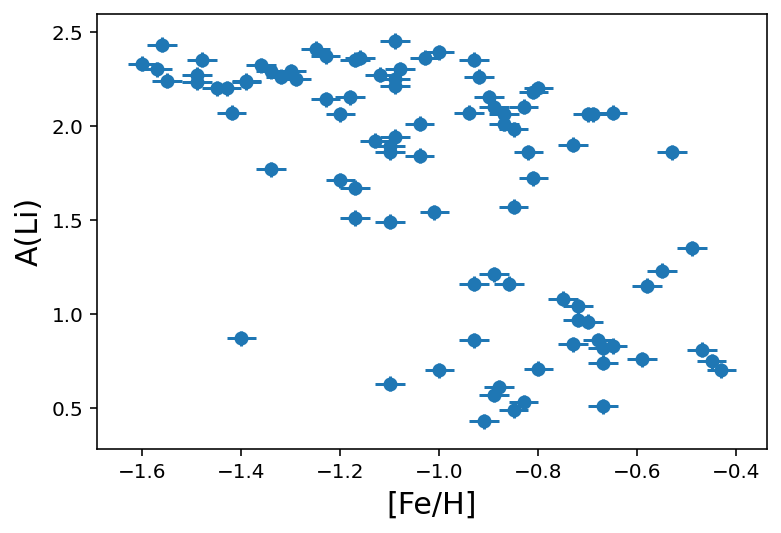

In [548]:
for keys in table.keys():
    
    if (keys[-2:] == '_h') & (keys[:2] != 'e_') & (keys[:5] != 'flag_') & (keys != 'fe_h'):
        element = keys[:-2]
        element = element[0].upper()+element[1:]
        ylabel = '['+element+'/Fe]'
        ydata = table[keys] - table['fe_h']
        
    elif (keys == 'a_li'):
        element = 'Li'
        ylabel = 'A(Li)'
        ydata = table[keys]
        
        plt.figure()
        plt.errorbar(
            table['fe_h'],
            ydata,
            xerr = table['e_fe_h'],
            yerr = table['e_'+keys],
            fmt = 'o'
        )
        plt.xlabel('[Fe/H]')
        plt.ylabel(ylabel)
        plt.show()
        plt.close()